## Machine Learning - Desafío 2, Expansiones basales
#### Gustavo Morales, G10 - 20.Nov.2019, (Miércoles Semana 1)

### Preparación del Ambiente de Trabajo y Descripción

Importamos las librerías pertinentes:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM #dado que el vector objectivo es continuo
from pygam.utils import generate_X_grid 
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
plt.style.use('seaborn-notebook')
%matplotlib inline

Cargamos el archivo y hacemos el trabajo exploratorio:

In [2]:
fname = 'compresive_strength_concrete.csv'
df = pd.read_csv(fname)
df.sample(5)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
12,427.5,47.5,0.0,228.0,0.0,932.0,594.0,270,43.01
548,289.0,0.0,0.0,192.0,0.0,913.2,895.3,28,25.57
904,155.0,183.0,0.0,193.0,9.0,877.0,868.0,28,23.79
752,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,14,59.76
206,212.1,0.0,121.6,180.3,5.7,1057.6,779.3,28,24.90


In [3]:
df.rename(columns={'Cement (component 1)(kg in a m^3 mixture)':'cement',
                   'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': 'blast_furnace_slag',
                   'Fly Ash (component 3)(kg in a m^3 mixture)': 'fly_ash',
                   'Water  (component 4)(kg in a m^3 mixture)': 'water',
                   'Superplasticizer (component 5)(kg in a m^3 mixture)': 'superplasticizer',
                   'Coarse Aggregate  (component 6)(kg in a m^3 mixture)': 'coarse_agg',
                   'Fine Aggregate (component 7)(kg in a m^3 mixture)': 'fine_agg',
                   'Age (day)': 'age',
                   'Concrete compressive strength(MPa, megapascals) ': 'ccs'},
          inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement                1030 non-null float64
blast_furnace_slag    1030 non-null float64
fly_ash               1030 non-null float64
water                 1030 non-null float64
superplasticizer      1030 non-null float64
coarse_agg            1030 non-null float64
fine_agg              1030 non-null float64
age                   1030 non-null int64
ccs                   1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [5]:
df.isnull().sum(axis = 0)

cement                0
blast_furnace_slag    0
fly_ash               0
water                 0
superplasticizer      0
coarse_agg            0
fine_agg              0
age                   0
ccs                   0
dtype: int64

In [6]:
df.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age,ccs
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Gráficos de cajas:

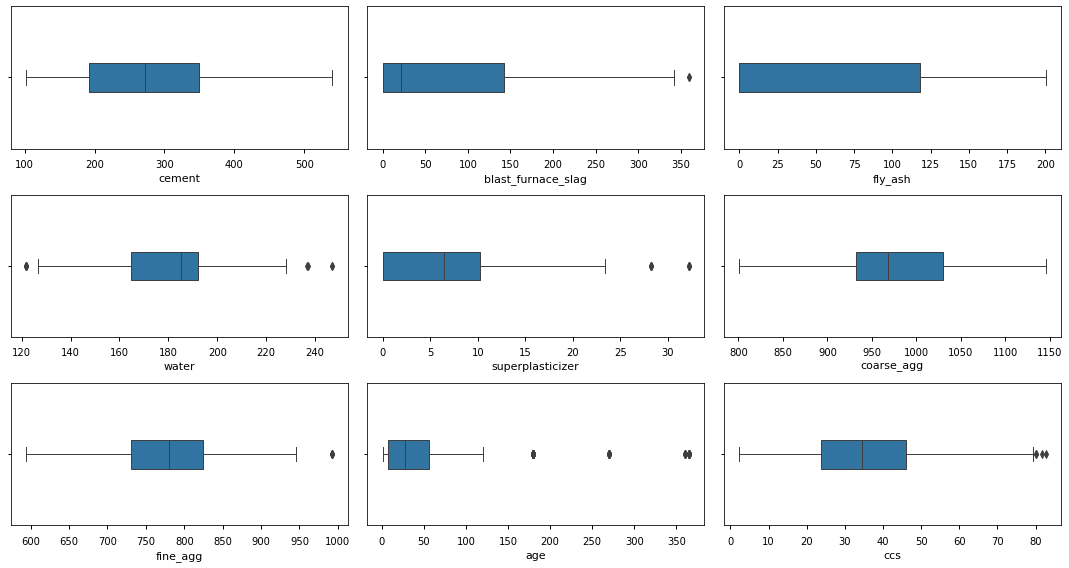

In [7]:
plt.rcParams['figure.figsize'] = 15, 8
var_lst = df.columns.tolist()
for i, var in enumerate(var_lst):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=df[var], width=0.2, color=None, linewidth=1.0)
plt.tight_layout()

Matriz de gráficos de distribuciones:

In [8]:
from scipy.stats import pearsonr
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top right hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    # rho = '\u03C1'
    ax.annotate(f'{r:.2f}', xy=(.85, .9), xycoords=ax.transAxes, fontsize=14)

In [9]:
def plot_pair_grid(dataframe, variables=None):
    grid = sns.PairGrid(data=dataframe, vars=variables, dropna=True)
    grid = grid.map_upper(sns.regplot, color='black', scatter_kws={'alpha': 0.1})
    grid = grid.map_upper(corrfunc)
    grid = grid.map_lower(sns.kdeplot, cmap='binary')
    grid = grid.map_diag(sns.distplot, kde=False, rug=True, color='black')
    plt.tight_layout()

In [10]:
vars1 = ['cement', 'blast_furnace_slag', 'fly_ash']
vars2 = ['water', 'superplasticizer', 'coarse_agg']
vars3 = ['fine_agg', 'age', 'ccs']

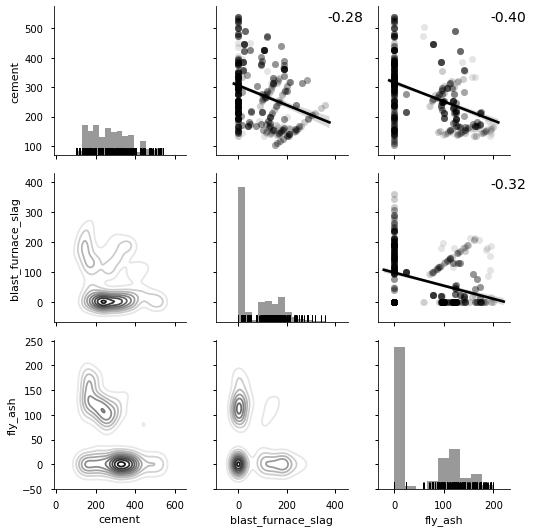

In [11]:
plot_pair_grid(df, variables=vars1)

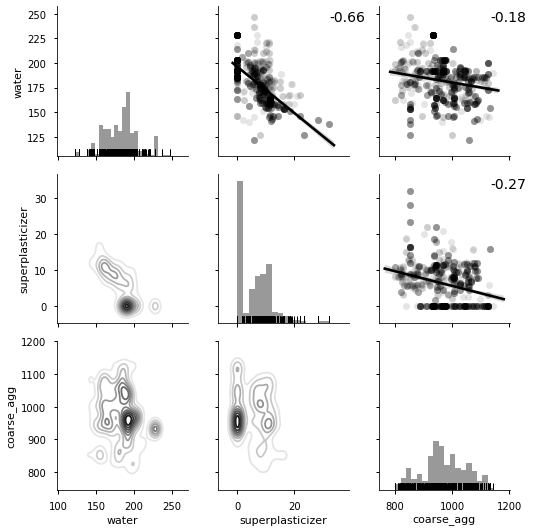

In [12]:
plot_pair_grid(df, variables=vars2)

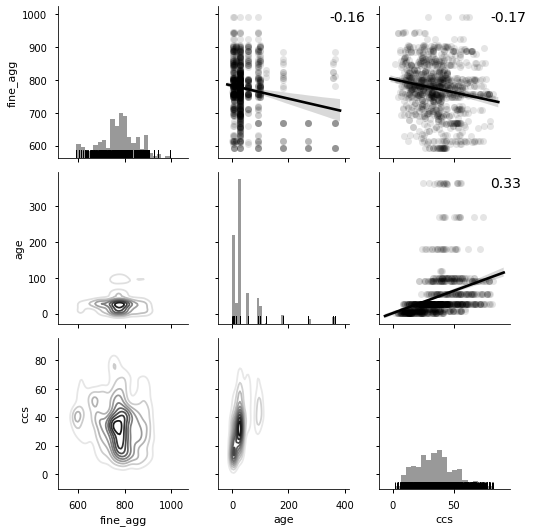

In [13]:
plot_pair_grid(df, variables=vars3)

Histogramas de las variables:

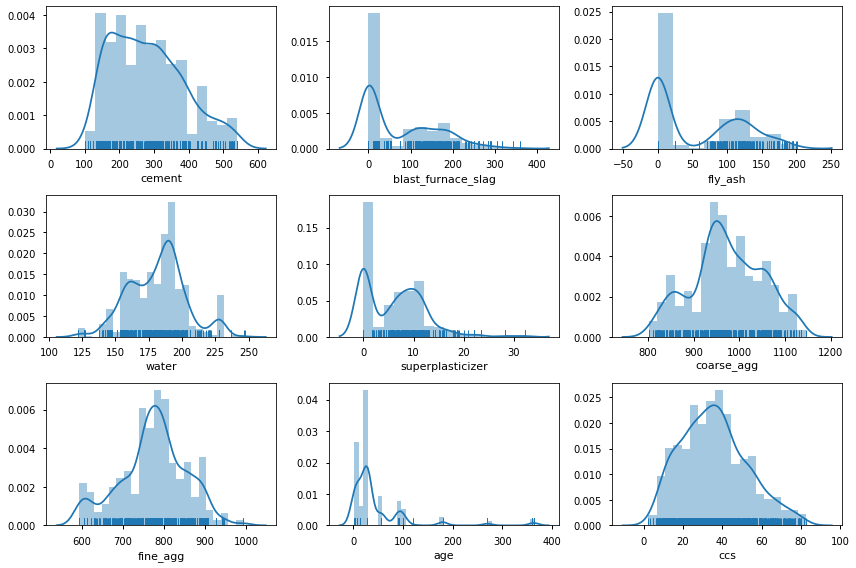

In [14]:
plt.rcParams['figure.figsize'] = 12, 8
for i, var in enumerate(var_lst):
    plt.subplot(3,3,i+1)
    sns.distplot(df[var], rug=True)
plt.tight_layout()

**(R)** Las distribuciones se ven bien comportadas.

### Modelación

Voy a aplicar una estandarización para reescalar las distribuciones (asumidas gaussianas):

In [15]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [16]:
X = df.drop(['ccs'], axis=1)  # features
y = df['ccs']  # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=63)

**(1)** Modelo sin implementar `gridsearch` con `lam = 1000`:

In [17]:
gam_1000 = LinearGAM(lam = 1e3)
gam_1000.fit(X_train, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], constraints=None, 
   dtype='auto', fit_intercept=True, fit_linear=False, 
   fit_splines=True, lam=1000.0, max_iter=100, n_splines=25, 
   penalties='auto', scale=None, spline_order=3, tol=0.0001, 
   verbose=False)

In [18]:
gam_1000.lam

1000.0

In [19]:
gam_1000.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     22.1139
Link Function:                     IdentityLink Log Likelihood:                                 -1274.7837
Number of Samples:                          690 AIC:                                             2595.7951
                                                AICc:                                            2597.4692
                                                GCV:                                                0.1963
                                                Scale:                                               0.185
                                                Pseudo R-Squared:                                   0.8231
Feature Function   Data Type      Num

**(2)** Modelo con `gridsearch` que usa por defecto un `logspace` entre -3 y 3:

In [20]:
gam_gs = LinearGAM().gridsearch(X_train, y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [21]:
gam_gs.lam

0.25118864315095796

In [22]:
gam_gs.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    106.8637
Link Function:                     IdentityLink Log Likelihood:                                 -2421.7093
Number of Samples:                          690 AIC:                                              5059.146
                                                AICc:                                             5099.558
                                                GCV:                                                0.1147
                                                Scale:                                              0.0832
                                                Pseudo R-Squared:                                   0.9305
Feature Function   Data Type      Num

El mejor modelo se puede decidir mirando las siguientes métricas:

In [23]:
R2= [(r2_score(gam_1000.predict(X_test), y_test)),
     (r2_score(gam_gs.predict(X_test), y_test))]
MSE= [(mean_squared_error(gam_1000.predict(X_test), y_test)),
       (mean_squared_error(gam_gs.predict(X_test), y_test))]
MAE= [(median_absolute_error(gam_1000.predict(X_test), y_test)),
      (median_absolute_error(gam_gs.predict(X_test), y_test))]
pd.DataFrame(data={'R2': R2, 'MSE': MSE, 'MAE': MAE},
             index=['GAM_1000','GAM_Grid']).transpose()

,GAM_1000,GAM_Grid
R2,0.746215,0.888102
MSE,0.193148,0.108560
MAE,0.274440,0.215701


**(R)** Es decir, claramente el mejor modelo es el que sale de usar el método `grid_search`: tiene mejor R$^2$, y diferencias MSE y MAE más pequeñas.

### Dependencia Parcial

In [24]:
def plot_partial_dep(gam_model, attributes):
    X_grid = generate_X_grid(gam_model)
    for i, n in enumerate(range(len(attributes))):
        plt.subplot(2, 4, i + 1)
        partial_dep, confidence_intervals = gam_model.partial_dependence(X_grid,
                                                                         feature=i+1,
                                                                         width=.95)
        plt.plot(X_grid[:, n], partial_dep, color='tomato')
        plt.fill_between(X_grid[:, n],
                         confidence_intervals[0][:, 0],
                         confidence_intervals[0][:,1],
                         alpha=.25)
        plt.title(attributes[n])
        plt.scatter(X_train[attributes[n]],
                    [plt.ylim()[0]] * len(X_train[attributes[n]]),
                    marker='|', alpha=.5)
    plt.tight_layout()

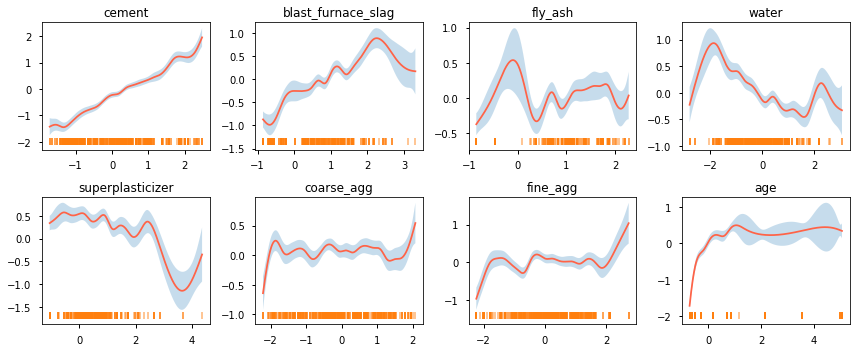

In [25]:
plt.rcParams['figure.figsize'] = 12, 5
plot_partial_dep(gam_gs, X_train.columns)

**(R)** Estos gráficos representan el valor predicho para la resistencia compresiva del concreto:

* `cement`: a mayor cantidad de cemento hay mayor resistencia a la compresión del concreto.
* `blast_furnace_slag`: a mayor escoria metalúrgica la resistencia a la compresión es mayor, hasta cierto valor crítico en donde comienza a disminuir.
* `fly_ash`: respecto de las cenizas el comportamiento es más bien variable.
* `water`: en general, a menor cantidad de agua mayor es la resistencia.
* `superplasticizer`: salvo variaciones a escalas menores, a mayor cantidad de plastificante la resitencia del concreto disminuye.
* `coarse_agg`: el espesante grueso tiende a no tener influencia en la resistencia, salvo a escalas más grandes.
* `fine_agg`: lo mismo se puede decir para el espesante más fino.
* `age`: la resistencia del concreto se incrementa rápidamente con los días, estabilizándose luego de cierto valor crítico.

**(R)**
- Atributos asociados a mayores niveles de resistencia: `cement`, `blast_furnace_slag`, y ambos espesantes a escalas grandes.
- Atributos asociados a mayores niveles de resistencia: `superplasticizer` y `water`, ambos a escalas grandes, y lógicamente `age` a escalas muy chicas. 